In [9]:
%pip install matplotlib



  Using cached matplotlib-3.9.1-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.2.1-cp311-cp311-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.1-cp311-cp311-win_amd64.whl.metadata (165 kB)
  Using cached kiwisolver-1.4.5-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.9.1-cp311-cp311-win_amd64.whl (8.0 MB)
Using cached contourpy-1.2.1-cp311-cp311-win_amd64.whl (188 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.53.1-cp311-cp311-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.5-cp311-cp311-win_amd64.whl (56 kB)
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.472777..3.5713003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.5231833..5.9291353].


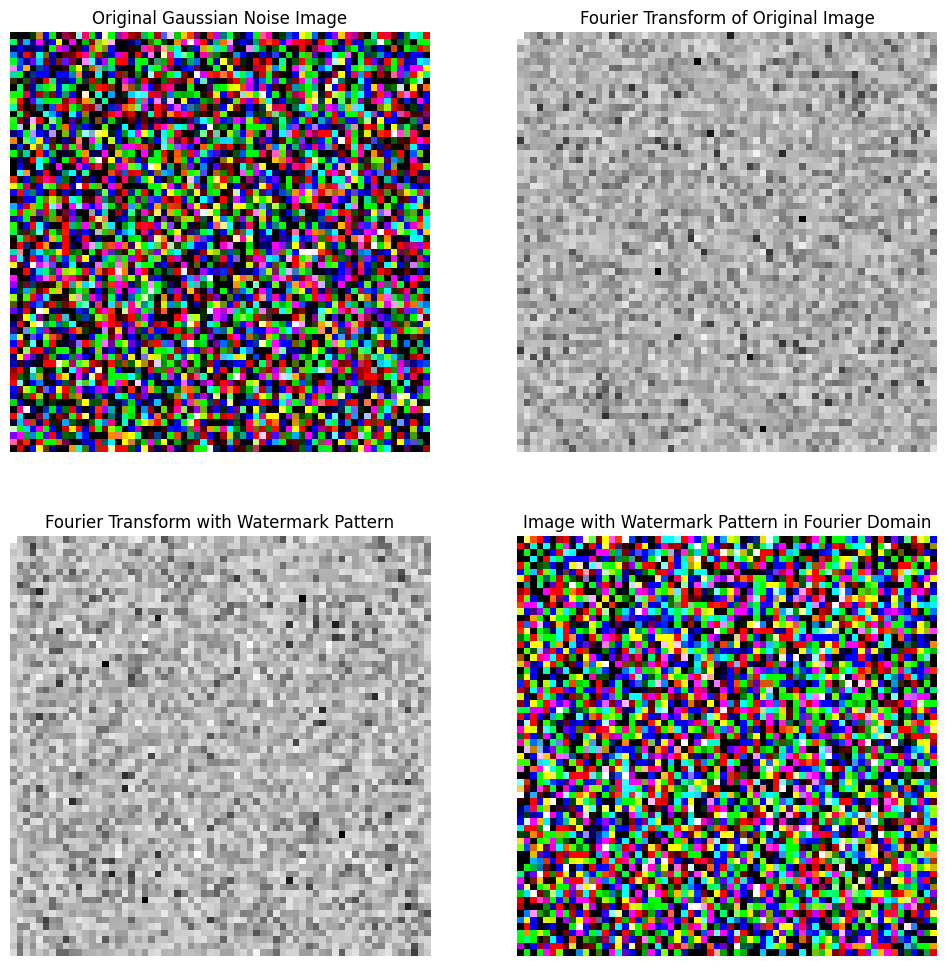

In [10]:
import torch
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt

# Dummy functions and classes to make the example work
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

def circle_mask(dimension, r):
    center = dimension // 2
    Y, X = np.ogrid[:dimension, :dimension]
    dist_from_center = np.sqrt((X - center)**2 + (Y - center)**2)
    mask = dist_from_center <= r
    return mask

# Arguments simulation
class Args:
    def __init__(self):
        self.w_seed = 42
        self.w_pattern = 'ring'
        self.w_radius = 5
        self.w_pattern_const = 0.1

args = Args()
device = 'cpu'
shape = (1, 3, 64, 64)  # example shape

# Function to be tested
def get_watermarking_pattern(args, device, shape=None):
    set_random_seed(args.w_seed)
    gt_init = torch.randn(*shape, device=device)

    if 'seed_ring' in args.w_pattern:
        gt_patch = gt_init

        gt_patch_tmp = copy.deepcopy(gt_patch)
        for i in range(args.w_radius, 0, -1):
            tmp_mask = circle_mask(gt_init.shape[-1], r=i)
            tmp_mask = torch.tensor(tmp_mask).to(device)
            
            for j in range(gt_patch.shape[1]):
                gt_patch[:, j, tmp_mask] = gt_patch_tmp[0, j, 0, i].item()
    elif 'seed_zeros' in args.w_pattern:
        gt_patch = gt_init * 0
    elif 'seed_rand' in args.w_pattern:
        gt_patch = gt_init
    elif 'rand' in args.w_pattern:
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2))
        gt_patch[:] = gt_patch[0]
    elif 'zeros' in args.w_pattern:
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2)) * 0
    elif 'const' in args.w_pattern:
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2)) * 0
        gt_patch += args.w_pattern_const
    elif 'ring' in args.w_pattern:
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2))

        gt_patch_tmp = copy.deepcopy(gt_patch)
        for i in range(args.w_radius, 0, -1):
            tmp_mask = circle_mask(gt_init.shape[-1], r=i)
            tmp_mask = torch.tensor(tmp_mask).to(device)
            
            for j in range(gt_patch.shape[1]):
                gt_patch[:, j, tmp_mask] = gt_patch_tmp[0, j, 0, i].item()

    return gt_patch

# Generate random Gaussian noise image
image = torch.randn(1, 3, 64, 64, device=device)

# Compute Fourier transform
ft_image = torch.fft.fftshift(torch.fft.fft2(image), dim=(-1, -2))

# Generate watermark pattern
gt_patch = get_watermarking_pattern(args, device, shape)

# Apply watermark pattern to Fourier transform
ft_image_with_pattern = ft_image + gt_patch

# Compute inverse Fourier transform
image_with_pattern = torch.fft.ifft2(torch.fft.ifftshift(ft_image_with_pattern), dim=(-1, -2)).real

# Visualization function
def visualize_images(original, ft_original, modified_ft, modified):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    axes[0, 0].imshow(original[0].permute(1, 2, 0).cpu().numpy(), cmap='gray')
    axes[0, 0].set_title('Original Gaussian Noise Image')

    axes[0, 1].imshow(np.log1p(torch.abs(ft_original[0, 0]).cpu().numpy()), cmap='gray')
    axes[0, 1].set_title('Fourier Transform of Original Image')

    axes[1, 0].imshow(np.log1p(torch.abs(modified_ft[0, 0]).cpu().numpy()), cmap='gray')
    axes[1, 0].set_title('Fourier Transform with Watermark Pattern')

    axes[1, 1].imshow(modified[0].permute(1, 2, 0).cpu().numpy(), cmap='gray')
    axes[1, 1].set_title('Image with Watermark Pattern in Fourier Domain')

    for ax in axes.flatten():
        ax.axis('off')

    plt.show()

# Visualize the results
visualize_images(image, ft_image, ft_image_with_pattern, image_with_pattern)


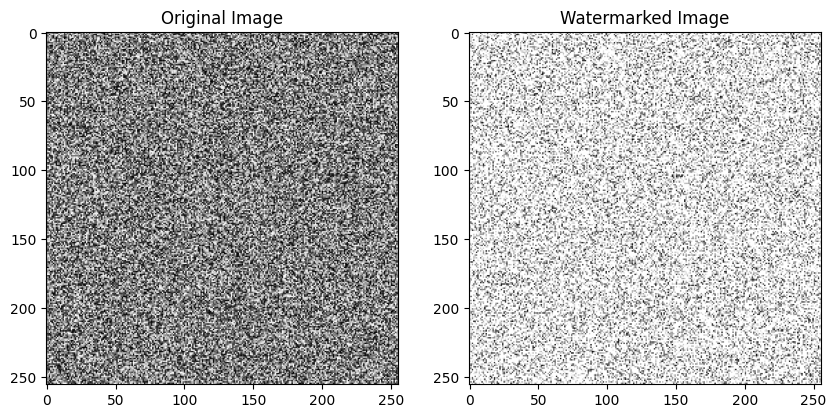

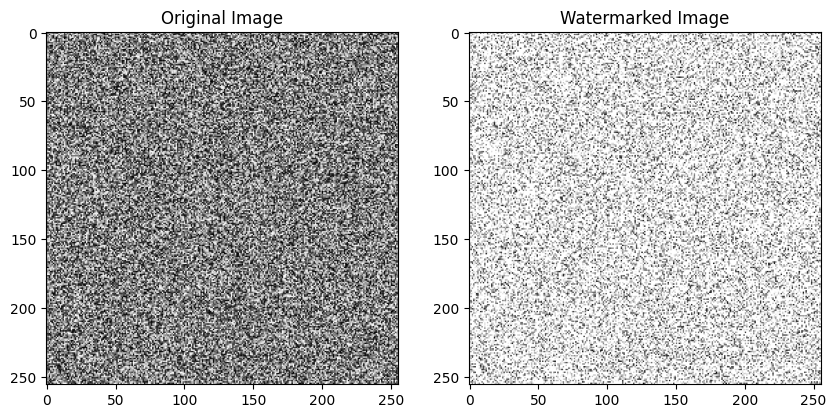

In [15]:
import numpy as np
import torch
import random
from PIL import Image
import matplotlib.pyplot as plt

def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def generate_random_watermark(image_size, seed):
    set_random_seed(seed)
    # Generate a random watermark pattern
    watermark_pattern = np.random.rand(image_size, image_size)
    return watermark_pattern

def apply_watermark(image, watermark_pattern):
    # For simplicity, add the watermark pattern to the image
    watermarked_image = image + watermark_pattern
    return np.clip(watermarked_image, 0, 1)  # Ensure pixel values are within valid range

# Set parameters
image_size = 256
seed1 = 24  # You can change this seed to see different results
seed2=9999999
# Load an example image (we'll use a dummy image here)
image = np.random.rand(image_size, image_size)

# Generate the watermark pattern using the specified seed
watermark_pattern1 = generate_random_watermark(image_size, seed1)
watermark_pattern2 = generate_random_watermark(image_size, seed2)

# Apply the watermark to the image
watermarked_image1 = apply_watermark(image, watermark_pattern1)
watermarked_image2 = apply_watermark(image, watermark_pattern2)

# Display the original and watermarked images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Watermarked Image')
plt.imshow(watermarked_image1, cmap='gray')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Watermarked Image')
plt.imshow(watermarked_image2, cmap='gray')
plt.show()


In [1]:
pip install numpy matplotlib scipy


  Using cached scipy-1.14.0-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.14.0-cp311-cp311-win_amd64.whl (44.7 MB)
Note: you may need to restart the kernel to use updated packages.


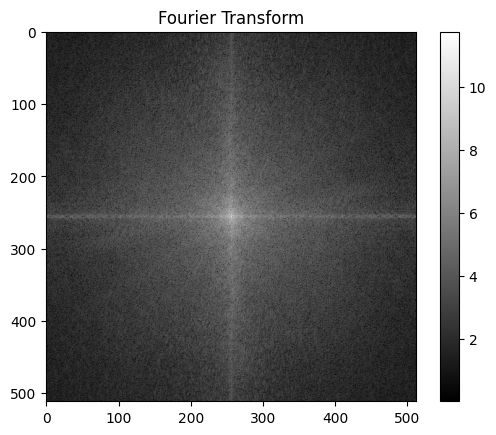

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Load image
image = imread('C:\\Users\\nites\\Downloads\\tree-ring-watermark-main (1)\\tree-ring-watermark-main\\output_images\\output9\image_0\\orig_image_w_0.png')

# Convert to grayscale if it's a color image
if len(image.shape) == 3:
    image = np.mean(image, axis=2)
# Compute the 2D FFT
fft_image = np.fft.fft2(image)

# Shift the zero frequency component to the center
fft_image_centered = np.fft.fftshift(fft_image)
# Compute the magnitude spectrum
magnitude_spectrum = np.abs(fft_image_centered)

# Use a logarithmic scale for better visualization
magnitude_spectrum_log = np.log(1 + magnitude_spectrum)

# Plot the result
plt.imshow(magnitude_spectrum_log, cmap='gray')
plt.title('Fourier Transform')
plt.colorbar()
plt.show()



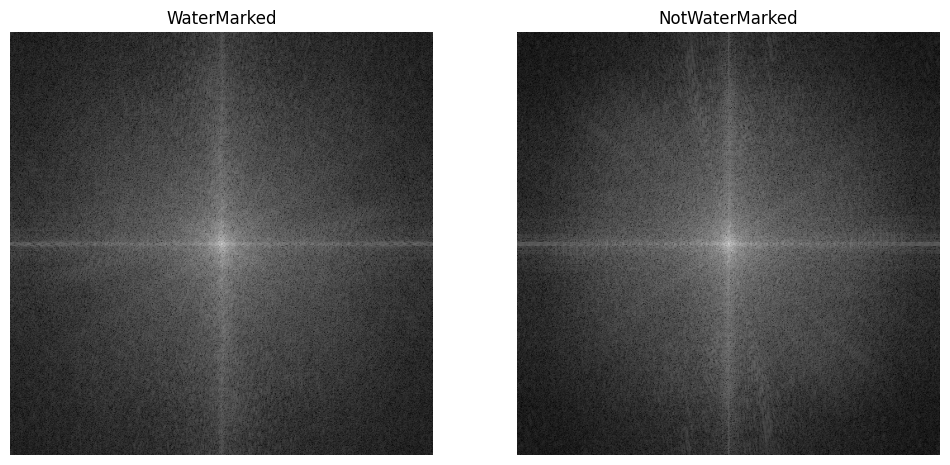

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

def compute_fft(image_path):
    # Load image
    image = imread(image_path)
    
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)
    
    # Compute the 2D FFT
    fft_image = np.fft.fft2(image)
    
    # Shift the zero frequency component to the center
    fft_image_centered = np.fft.fftshift(fft_image)
    
    # Compute the magnitude spectrum
    magnitude_spectrum = np.abs(fft_image_centered)
    
    # Use a logarithmic scale for better visualization
    magnitude_spectrum_log = np.log(1 + magnitude_spectrum)
    
    return magnitude_spectrum_log

# Paths to your images
image_path1 = 'C:\\Users\\nites\\Downloads\\tree-ring-watermark-main (1)\\tree-ring-watermark-main\\output_images\\output9\\image_0\\orig_image_w_0.png'
image_path2 = 'C:\\Users\\nites\\Downloads\\tree-ring-watermark-main (1)\\tree-ring-watermark-main\\output_images\\output9\\image_0\\orig_image_no_w_0.png'

# Compute FFT for both images
magnitude_spectrum_log1 = compute_fft(image_path1)
magnitude_spectrum_log2 = compute_fft(image_path2)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display first image
ax[0].imshow(magnitude_spectrum_log1, cmap='gray')
ax[0].set_title('WaterMarked')
ax[0].axis('off')  # Hide axes

# Display second image
ax[1].imshow(magnitude_spectrum_log2, cmap='gray')
ax[1].set_title('NotWaterMarked')
ax[1].axis('off')  # Hide axes

plt.show()
